In [145]:
import torchvision
import torch
import numpy as np
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
plt.rcParams['image.cmap'] = 'gray'

In [146]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1)
])
dataset = torchvision.datasets.MNIST(root='data', transform=transforms, download=True)
data_five = Subset(dataset, np.where(dataset.targets == 5)[0])

dataloader = DataLoader(data_five, batch_size=16, shuffle=True)

In [147]:
len(data_five)

5421

In [148]:
torch.min(data_five[0][0]), torch.max(data_five[0][0]), data_five[0][0].shape

(tensor(0.), tensor(1.), torch.Size([1, 28, 28]))

In [149]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

In [150]:
class GanComponent(torch.nn.Module):
    def __init__(self):
        super(GanComponent, self).__init__()

    def lock(self):
        for param in self.parameters():
            param.requires_grad = False

    def unlock(self):
        for param in self.parameters():
            param.requires_grad = True

In [151]:
class Generator(GanComponent):
    def __init__(self, input_length, output_image_size):
        super(Generator, self).__init__()
        self.input = torch.nn.Linear(input_length, 256)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=.3)
        self.h1 = torch.nn.Linear(self.input.out_features, self.input.out_features*2)
        self.h2 = torch.nn.Linear(self.h1.out_features, self.h1.out_features*2)
        self.output = torch.nn.Linear(self.h2.out_features, output_image_size[1] * output_image_size[2])
        self.sigmoid = torch.nn.Tanh()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [152]:
class Discriminator(GanComponent):
    def __init__(self, input_image_size):
        super(Discriminator, self).__init__()

        self.input = torch.nn.Linear(input_image_size[1] * input_image_size[2], 1024)
        self.activation = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(p=.3)
        self.h1 = torch.nn.Linear(self.input.out_features, self.input.out_features // 2)
        self.h2 = torch.nn.Linear(self.h1.out_features, self.h1.out_features // 2)
        self.output = torch.nn.Linear(self.h2.out_features, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

<h3> Training </h3>

In [153]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_shape = data_five[0][0].shape
noise_vector_length = 200
gen = Generator(noise_vector_length, data_five[0][0].shape)
gen = gen.to(device)
gen.apply(weights_init)
discr = Discriminator(data_five[0][0].shape)
discr.apply(weights_init)
discr = discr.to(device)

n_iterations = 10
k = 1

criterion = torch.nn.BCELoss()

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=.00001)
discr_optimizer = torch.optim.Adam(discr.parameters(), lr=.00001)

for i in tqdm(range(n_iterations)):
    running_discr_loss, running_gen_loss = 0.0, 0.0

    for batch, _ in dataloader:
        batch = batch.to(device)

        # Update Discriminator
        discr.zero_grad()
        # Train with real batch
        discr_real_output = discr(batch.flatten(start_dim=1))
        loss_D_real = criterion(discr_real_output, torch.ones(batch.shape[0], 1, device=device))
        loss_D_real.backward()

        # Train with fake batch
        noise_batch = torch.normal(0, 1, size=(batch.shape[0], noise_vector_length), device=device)
        fake = gen(noise_batch)
        discr_fake_output = discr(fake.detach())

        loss_D_fake = criterion(discr_fake_output, torch.zeros(batch.shape[0], 1, device=device))
        loss_D_fake.backward()
        loss_D = loss_D_real + loss_D_fake
        running_discr_loss += loss_D.item()

        discr_optimizer.step()

        # Update generator
        gen.zero_grad()
        discr_output = discr(fake)
        loss_G = criterion(discr_output, torch.ones(batch.shape[0], 1, device=device))
        running_gen_loss += loss_G.item()

        loss_G.backward()
        gen_optimizer.step()

        # # noise_batch = torch.rand((batch.shape[0], noise_vector_length))
        #
        # discr_real_output = discr(batch.flatten(start_dim=1))
        # discr_fake_output = discr(gen(noise_batch))
        # # discr_loss = ((torch.log(discr_real_output) + torch.log(1-discr_fake_output))).mean()
        # running_discr_loss += discr_loss.item()
        # discr_optimizer.zero_grad()
        # discr_loss.backward()
        # discr_optimizer.step()
        #
        # noise_batch = torch.rand((batch.shape[0], noise_vector_length), device=device)
        #
        # # gen_loss = torch.log(1-discr(gen(noise_batch))).mean()
        # running_gan_loss += gen_loss.item()
        #
        # gen_optimizer.zero_grad()
        # gen_loss.backward()
        # gen_optimizer.step()

    print(f"Discriminiator loss: {running_discr_loss/(len(dataloader))}, Generator loss: {running_gen_loss/len(dataloader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Discriminiator loss: 1.3142329454421997, Generator loss: 0.6149820658133797
Discriminiator loss: 1.2686309424121822, Generator loss: 0.7307853623125757
Discriminiator loss: 1.0255821600424504, Generator loss: 0.8762632982920756
Discriminiator loss: 0.6712571286698007, Generator loss: 1.1609250934778061
Discriminiator loss: 0.5169445342194717, Generator loss: 1.4576977811380123
Discriminiator loss: 0.3921645282819911, Generator loss: 2.016093026571921
Discriminiator loss: 0.32846400066990417, Generator loss: 2.426959173165943
Discriminiator loss: 0.3619104783355662, Generator loss: 2.450923764600163
Discriminiator loss: 0.28570647869577803, Generator loss: 2.856442598466676
Discriminiator loss: 0.22669695548515403, Generator loss: 3.2257960250595676


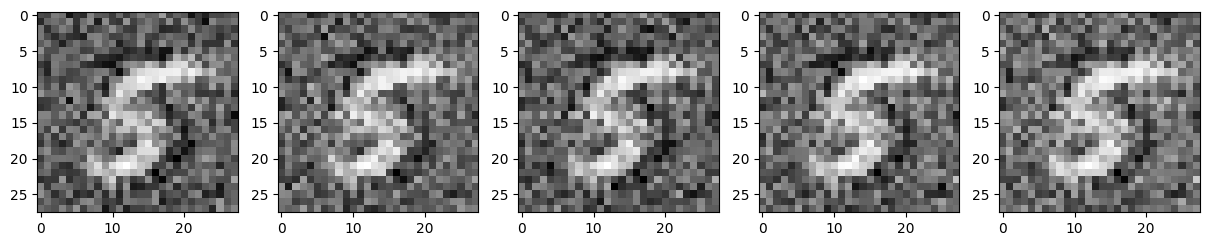

In [154]:
figs, axs = plt.subplots(1, 5, figsize=(15, 15))
# noise_sample = torch.rand((5, noise_vector_length))
noise_sample = torch.normal(0, 1, size=(5, noise_vector_length), device=device)

output = gen(noise_sample)
output_shape = dataset[0][0].shape
for i in range(5):
    reshaped = torch.reshape(output[i], output_shape)
    axs[i].imshow(reshaped.cpu().detach().numpy()[0])

In [155]:
noise_batch = torch.rand((1, noise_vector_length))

In [156]:
torch.min(noise_batch), torch.max(noise_batch)

(tensor(0.0060), tensor(0.9879))